# Assignment 2 - Randomized Optimization - mkecera3@gatech.edu

In [1]:
# imports
import mlrose
import numpy as np
import time
import itertools
import pandas as pd
import seaborn as sns
save_path = './charts/'

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/anaconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import random
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import array

## 4-peaks

In [3]:
# define the 4-peaks problem and print an example
fitness = mlrose.FourPeaks(t_pct=0.1)
state = np.array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0])
print(fitness.evaluate(state))
problem = mlrose.DiscreteOpt(length = 100, fitness_fn = fitness, maximize = True, max_val = 2)

16


In [4]:
def parameter_search(problem, algorithm, **kwargs):
    
    values = []
    names = []
    for key, value in kwargs.items():
        names.append(key)
        values.append(value)
    
    permutations = [(x, y) for x in values[0] for y in values[1]]
    param1 = [x[0] for x in permutations]
    param2 = [x[1] for x in permutations]

    all_states = []
    all_fitness = []
    all_curves = []
    run_times = []
    for permutation in permutations:
        start_time = time.time()
        param = {}
        param[names[0]] = permutation[0]
        param[names[1]] = permutation[1]
        best_state, best_fitness, curve = algorithm(
            problem=problem,
            curve=True,
            **param
            )
        end_time = time.time()
        run_time = end_time - start_time
        
        all_states.append(best_state)
        all_fitness.append(best_fitness)
        run_times.append(run_time)
        all_curves.append(curve)

    return all_states, all_fitness, all_curves, run_times, param1, param2

### Randomized hill climbing

In [5]:
# define the size of the testing
restart_options = list(np.geomspace(10, 1000, 8))
max_attempts_options = list(np.geomspace(10, 500, 8))
restart_options = [int(x) for x in restart_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [6]:
all_states, all_fitness, all_curves, run_times, restart_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.random_hill_climb,
    restarts=restart_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

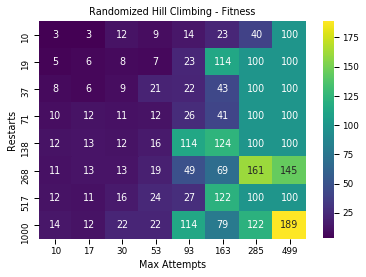

In [7]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing - Fitness')
sns_plot.get_figure().savefig(save_path + "4p_rhc_hyperparam.png", dpi=100)

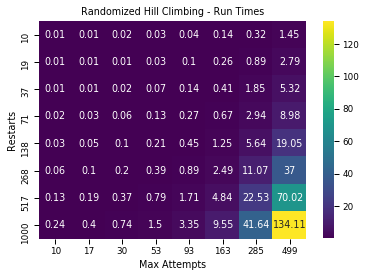

In [8]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing - Run Times')
sns_plot.get_figure().savefig(save_path + "4p_rhc_hyperparam-time.png", dpi=100)

### Simulated annealing

In [9]:
iters_options = list(np.geomspace(10, 10000, 8))
max_attempts_options = list(np.geomspace(10, 10000, 8))
iters_options = [int(x) for x in iters_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [10]:
all_states, all_fitness, all_curves, run_times, max_iter_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.simulated_annealing,
    max_iters=iters_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

/anaconda3/envs/ml/lib/python3.6/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


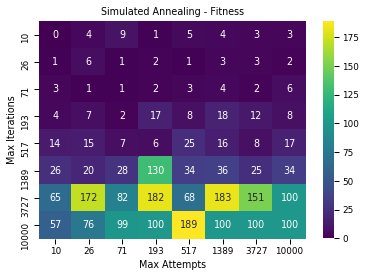

In [11]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing - Fitness')
sns_plot.get_figure().savefig(save_path + "4p_sa_hyperparam.png", dpi=100)

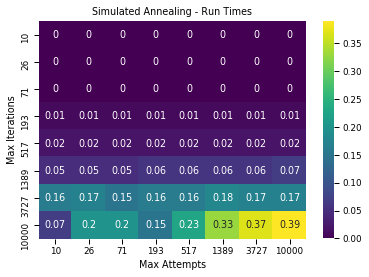

In [12]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing - Run Times')
sns_plot.get_figure().savefig(save_path + "4p_sa_hyperparam-time.png", dpi=100)

### Genetic Algorithm

In [13]:
pop_size = list(np.geomspace(200, 20000, 8))
mut_prob = list(np.linspace(0, 0.5, 8))
pop_size = [int(x) for x in pop_size]
mut_prob = [round(x, 2) for x in mut_prob]

In [14]:
all_states, all_fitness, all_curves, run_times, pop_size_data, mut_prob_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.genetic_alg,
    pop_size=pop_size, 
    mutation_prob=mut_prob,
    curve=True
    )

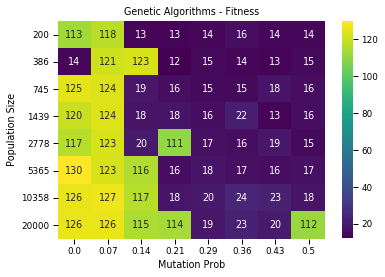

In [15]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms - Fitness')
sns_plot.get_figure().savefig(save_path + "4p_ga_hyperparam.png", dpi=100)

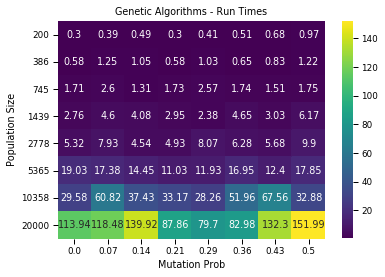

In [16]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms - Run Times')
sns_plot.get_figure().savefig(save_path + "4p_ga_hyperparam-time.png", dpi=100)

### MIMIC

In [66]:
pop_size = list(np.geomspace(50, 500, 8))
keep_pct = list(np.linspace(0.1, 0.4, 8))
pop_size = [int(x) for x in pop_size]
keep_pct = [round(x, 2) for x in keep_pct]

In [67]:
all_states, all_fitness, all_curves, run_times, pop_size_data, keep_perc_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.mimic,
    pop_size=pop_size, 
    keep_pct=keep_pct,
    curve=True
    )

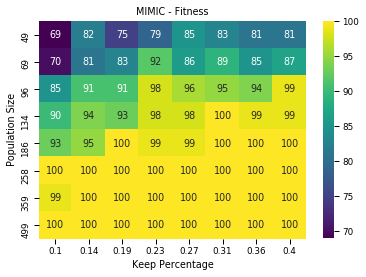

In [68]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Keep Percentage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC - Fitness')
sns_plot.get_figure().savefig(save_path + "mimic_hyperparam.png", dpi=100)

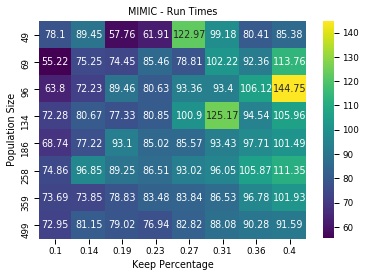

In [69]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Keep Percentage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC - Run Times')
sns_plot.get_figure().savefig(save_path + "mimic_hyperparam-time.png", dpi=100)

## Knapsack

In [70]:
# define the Knapsack problem and print an example
value = [1, 5, 10, 20, 5, 1, 10, 5, 8]
weight = [5, 5, 15, 7, 12, 10, 20, 1, 7]
max_weight = 0.6
fitness = mlrose.Knapsack(weights=weight, values=value, max_weight_pct=max_weight)
state = np.array([1, 0, 1, 0, 1, 0, 0, 1, 0])
print(fitness.evaluate(state))
problem = mlrose.DiscreteOpt(length = 9, fitness_fn = fitness, maximize = True, max_val = 2)

21


### Randomized hill climbing

In [71]:
# define the size of the testing
restart_options = list(np.geomspace(10, 1000, 8))
max_attempts_options = list(np.geomspace(10, 500, 8))
restart_options = [int(x) for x in restart_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [72]:
all_states, all_fitness, all_curves, run_times, restart_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.random_hill_climb,
    restarts=restart_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

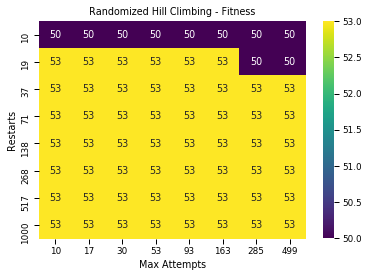

In [73]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing - Fitness')
sns_plot.get_figure().savefig(save_path + "ks_rhc_hyperparam.png", dpi=100)

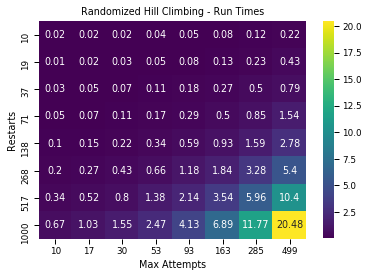

In [74]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing - Run Times')
sns_plot.get_figure().savefig(save_path + "ks_rhc_hyperparam-time.png", dpi=100)

### Simulated Annealing

In [75]:
iters_options = list(np.geomspace(10, 10000, 8))
max_attempts_options = list(np.geomspace(10, 10000, 8))
iters_options = [int(x) for x in iters_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [76]:
all_states, all_fitness, all_curves, run_times, max_iter_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.simulated_annealing,
    max_iters=iters_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

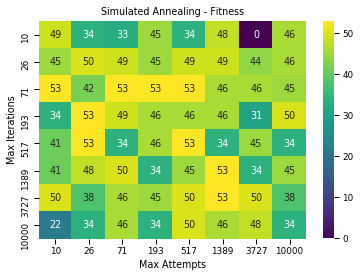

In [77]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing - Fitness')
sns_plot.get_figure().savefig(save_path + "ks_sa_hyperparam.png", dpi=100)

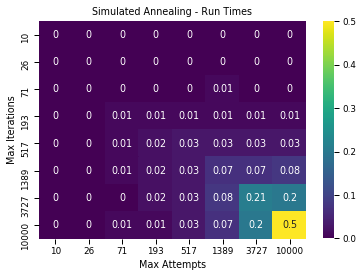

In [78]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing - Run Times')
sns_plot.get_figure().savefig(save_path + "ks_sa_hyperparam-time.png", dpi=100)

### Genetic Algorithm

In [79]:
pop_size = list(np.geomspace(200, 20000, 8))
mut_prob = list(np.linspace(0, 0.5, 8))
pop_size = [int(x) for x in pop_size]
mut_prob = [round(x, 2) for x in mut_prob]

In [80]:
all_states, all_fitness, all_curves, run_times, pop_size_data, mut_prob_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.genetic_alg,
    pop_size=pop_size, 
    mutation_prob=mut_prob,
    curve=True
    )

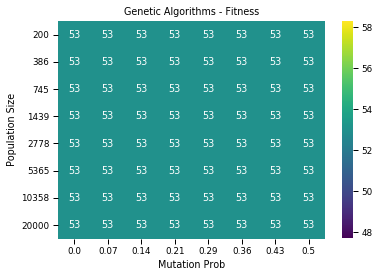

In [81]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms - Fitness')
sns_plot.get_figure().savefig(save_path + "ks_ga_hyperparam.png", dpi=100)

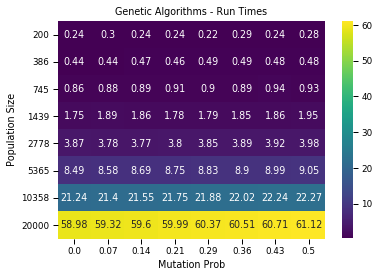

In [82]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms - Run Times')
sns_plot.get_figure().savefig(save_path + "ks_ga_hyperparam-time.png", dpi=100)

### MIMIC

In [83]:
pop_size = list(np.geomspace(500, 500, 8))
keep_pct = list(np.linspace(0.1, 0.4, 8))
pop_size = [int(x) for x in pop_size]
keep_pct = [round(x, 2) for x in keep_pct]

In [105]:
all_states, all_fitness, all_curves, run_times, pop_size_data, keep_perc_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.mimic,
    pop_size=pop_size, 
    keep_pct=keep_pct,
    curve=True
    )

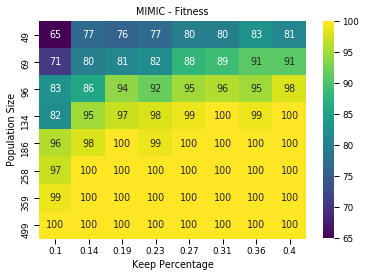

In [106]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Keep Percentage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC - Fitness')
sns_plot.get_figure().savefig(save_path + "ks_mimic_hyperparam.png", dpi=100)

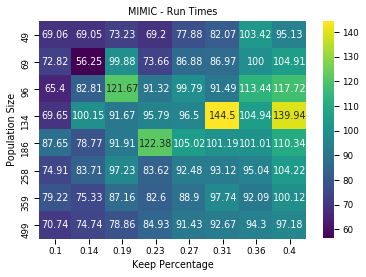

In [107]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Keep Percentage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC - Run Times')
sns_plot.get_figure().savefig(save_path + "ks_mimic_hyperparam-time.png", dpi=100)

## Count ones

In [108]:
# define the Count ones problem and print an example
fitness = mlrose.OneMax()
state = np.random.choice([0, 1], size=100, p=[0.5, 0.5])
print(fitness.evaluate(state))
problem = mlrose.DiscreteOpt(length = 100, fitness_fn = fitness, maximize = True, max_val = 2)

43


### Randomized hill climbing

In [109]:
# define the size of the testing
restart_options = list(np.geomspace(10, 1000, 8))
max_attempts_options = list(np.geomspace(10, 500, 8))
restart_options = [int(x) for x in restart_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [110]:
all_states, all_fitness, all_curves, run_times, restart_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.random_hill_climb,
    restarts=restart_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

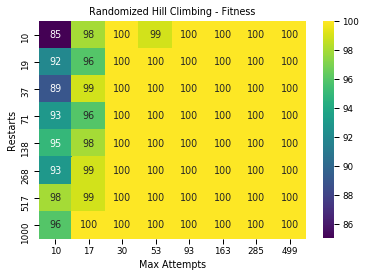

In [111]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing - Fitness')
sns_plot.get_figure().savefig(save_path + "co_rhc_hyperparam.png", dpi=100)

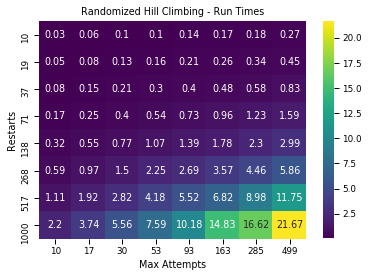

In [112]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Restarts': restart_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Restarts', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Randomized Hill Climbing - Run Times')
sns_plot.get_figure().savefig(save_path + "co_rhc_hyperparam-time.png", dpi=100)

### Simulated Annealing

In [113]:
iters_options = list(np.geomspace(10, 10000, 8))
max_attempts_options = list(np.geomspace(10, 10000, 8))
iters_options = [int(x) for x in iters_options]
max_attempts_options = [int(x) for x in max_attempts_options]

In [114]:
all_states, all_fitness, all_curves, run_times, max_iter_data, max_attempt_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.simulated_annealing,
    max_iters=iters_options, 
    max_attempts=max_attempts_options,
    curve=True
    )

/anaconda3/envs/ml/lib/python3.6/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


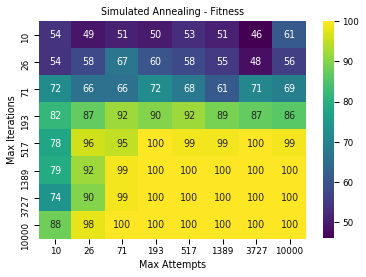

In [115]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing - Fitness')
sns_plot.get_figure().savefig(save_path + "co_sa_hyperparam.png", dpi=100)

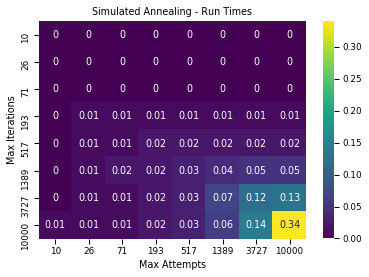

In [116]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Max Iterations': max_iter_data, 'Max Attempts': max_attempt_data})
chart_data = chart_data.pivot(index='Max Iterations', columns='Max Attempts', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Simulated Annealing - Run Times')
sns_plot.get_figure().savefig(save_path + "co_sa_hyperparam-time.png", dpi=100)

### Genetic Algorithm

In [117]:
all_states, all_fitness, all_curves, run_times, pop_size_data, mut_prob_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.genetic_alg,
    pop_size=pop_size, 
    mutation_prob=mut_prob,
    curve=True
    )

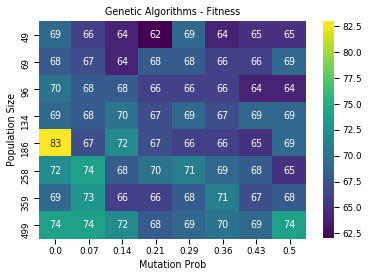

In [118]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms - Fitness')
sns_plot.get_figure().savefig(save_path + "co_ga_hyperparam.png", dpi=100)

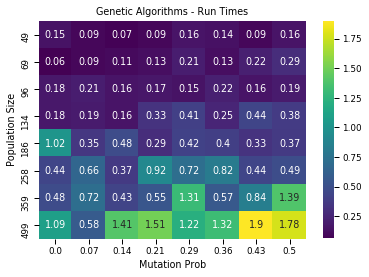

In [119]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Mutation Prob': mut_prob_data})
chart_data = chart_data.pivot(index='Population Size', columns='Mutation Prob', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('Genetic Algorithms - Run Times')
sns_plot.get_figure().savefig(save_path + "co_ga_hyperparam-time.png", dpi=100)

### MIMIC

In [120]:
pop_size = list(np.geomspace(50, 500, 8))
keep_pct = list(np.linspace(0.1, 0.4, 8))
pop_size = [int(x) for x in pop_size]
keep_pct = [round(x, 2) for x in keep_pct]

In [121]:
all_states, all_fitness, all_curves, run_times, pop_size_data, keep_perc_data = parameter_search(
    problem=problem, 
    algorithm=mlrose.mimic,
    pop_size=pop_size, 
    keep_pct=keep_pct,
    curve=True
    )

In [0]:
chart_data = pd.DataFrame({'Fitness': all_fitness, 'Population Size': pop_size_data, 'Keep Percentage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Fitness')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC - Fitness')
sns_plot.get_figure().savefig(save_path + "ks_mimic_hyperparam.png", dpi=100)

In [0]:
chart_data = pd.DataFrame({'Run Times': [round(x, 2) for x in run_times], 'Population Size': pop_size_data, 'Keep Percentage': keep_perc_data})
chart_data = chart_data.pivot(index='Population Size', columns='Keep Percentage', values='Run Times')
sns.set_context("paper")
sns_plot = sns.heatmap(chart_data, annot=True, fmt="g", cmap='viridis').set_title('MIMIC - Run Times')
sns_plot.get_figure().savefig(save_path + "ks_mimic_hyperparam-time.png", dpi=100)

# Neural Network

## MNIST

### Randomized hill climbing

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

train_sampler = torch.utils.data.sampler.RandomSampler(trainset, replacement=True, num_samples=5000)
val_sampler = torch.utils.data.sampler.RandomSampler(valset, replacement=True, num_samples=5000)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, sampler=val_sampler)

In [ ]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [ ]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [ ]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time0 = time.time()
    epochs = 30
    lossData = []
    accData = []
    runTime = []
    for e in range(epochs):
        startTime = time.time()
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        # testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        # print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])

        runTime.append(time.time() - startTime)
    
    return lossData, accData, runTime    
    print("\nTraining Time (in minutes) =",(time.time()-time0)/60)

In [ ]:
def trainNN_randomized_hill_climbing(model, stdev, restarts, max_iter):
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time0 = time.time()
    # epochs = epochs
    lossData = []
    accData = []
    runTime = []
    previous_loss = 999
    run = True
    iteration = 0
    restarted = 0
    total_iterations = 0
    update_ls = True
    best_loss_across = 999

    best_w1 = model[0].weight
    best_w2 = model[2].weight
    best_w3 = model[4].weight

    while run:
        startTime = time.time()
        running_loss = 0

        state = np.random.normal(0, stdev, 109184)

        l1 = torch.tensor(np.reshape(state[0:100352], (128, 784)).astype(np.float32))
        l2 = torch.tensor(np.reshape(state[100352:108544], (64, 128)).astype(np.float32))
        l3 = torch.tensor(np.reshape(state[108544:109184], (10, 64)).astype(np.float32))
        # print(l1.shape)
        # print(torch.nn.Parameter(l3))

        with torch.no_grad():
            orig_w1 = model[0].weight
            orig_w2 = model[2].weight
            orig_w3 = model[4].weight

        with torch.no_grad():
            model[0].weight = torch.nn.Parameter(model[0].weight + l1)
            model[2].weight = torch.nn.Parameter(model[2].weight + l2)
            model[4].weight = torch.nn.Parameter(model[4].weight + l3)

        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
        else:
            current_loss = running_loss/len(trainloader)
            # print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

        print(
            'Restarted: ' + str(restarted),
            'Iteration: ' + str(iteration), 
            'Previous loss: ' + str(round(previous_loss, 3)), 
            'Current loss: ' + str(round(current_loss, 3)),
            'Best loss: ' + str(round(best_loss_across, 3))
            )
        
        if current_loss > previous_loss:
            iteration += 1
            with torch.no_grad():
                model[0].weight = orig_w1
                model[2].weight = orig_w2
                model[4].weight = orig_w3
            
            if iteration > max_iter:

                restarted += 1

                if previous_loss < best_loss_across:
                    best_w1 = model[0].weight
                    best_w2 = model[2].weight
                    best_w3 = model[4].weight
                    best_loss_across = previous_loss
                    previous_loss = 999

                new_weights = np.random.normal(0, 0.01, 109184)
                n1 = torch.tensor(np.reshape(new_weights[0:100352], (128, 784)).astype(np.float32))
                n2 = torch.tensor(np.reshape(new_weights[100352:108544], (64, 128)).astype(np.float32))
                n3 = torch.tensor(np.reshape(new_weights[108544:109184], (10, 64)).astype(np.float32))

                model[0].weight = torch.nn.Parameter(n1)
                model[2].weight = torch.nn.Parameter(n2)
                model[4].weight = torch.nn.Parameter(n3)

                iteration = 0

                if restarted > restarts:
                    run = False
                    model[0].weight = best_w1
                    model[2].weight = best_w2
                    model[4].weight = best_w3
        else:
            previous_loss = current_loss
            # best_w1 = model[0].weight
            # best_w2 = model[2].weight
            # best_w3 = model[4].weight
            
            
        # testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        # print("Testing Loss  =", (testingLoss))
        
        lossData.append([total_iterations, running_loss/len(trainloader), 'Training Error'])
        # lossData.append([total_iterations, testingLoss, 'Testing Error'])
        # accData.append([total_iterations, correctCount / allCount])

        runTime.append(time.time() - startTime)
        total_iterations += 1

        # print(model[0].weight)
    
    return lossData, accData, runTime    

In [ ]:
lossDataBaseline, accDataBaseline, runtime = trainNN_randomized_hill_climbing(model, 0.001, 10, 500)

In [ ]:
# accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [ ]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
# accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

In [ ]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Randomized Hill Climbing')
# sns_plot.get_figure().savefig(save_path + "nn-randomized-hill.png", dpi=100)

In [ ]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [ ]:
correctCount / allCount, testingLoss

### Simulated Annealing

In [ ]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [ ]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [ ]:
def trainNN_simulated_annealing(model, stdev, max_iter, T, decay):
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    time0 = time.time()
    # epochs = epochs
    lossData = []
    accData = []
    runTime = []
    previous_loss = 999
    total_iterations = 0
    update_ls = True
    best_loss_across = 999

    best_w1 = model[0].weight
    best_w2 = model[2].weight
    best_w3 = model[4].weight

    for e in range(0, max_iter):
        startTime = time.time()
        running_loss = 0

        # state = np.random.normal(0, stdev, 109184)

        l1 = torch.tensor(np.random.normal(0, stdev, (128, 784)).astype(np.float32))
        l2 = torch.tensor(np.random.normal(0, stdev, (64, 128)).astype(np.float32))
        l3 = torch.tensor(np.random.normal(0, stdev, (10, 64)).astype(np.float32))
        # print(l1.shape)
        # print(torch.nn.Parameter(l3))

        with torch.no_grad():
            orig_w1 = model[0].weight
            orig_w2 = model[2].weight
            orig_w3 = model[4].weight

        with torch.no_grad():
            model[0].weight = torch.nn.Parameter(model[0].weight + l1)
            model[2].weight = torch.nn.Parameter(model[2].weight + l2)
            model[4].weight = torch.nn.Parameter(model[4].weight + l3)

        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
        else:
            current_loss = running_loss/len(trainloader)
            # print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

        print(
            'Iteration: ' + str(e), 
            'Previous loss: ' + str(round(previous_loss, 3)), 
            'Current loss: ' + str(round(current_loss, 3)),
            )
        
        if current_loss > previous_loss:
            loss_difference = current_loss - previous_loss
            prob_accept = np.exp(-loss_difference/(T))
            prob_uniform = np.random.uniform()
            # print('Loss difference: ' + str(loss_difference))
            # print('Prob of accepting the move: ' + str(prob_accept))
            # print('Prob hurdle: ' + str(prob_uniform))
            
            if prob_accept > prob_uniform:
                # print('Accepted worse solution')
                previous_loss = current_loss

            else:
                with torch.no_grad():
                    model[0].weight = orig_w1
                    model[2].weight = orig_w2
                    model[4].weight = orig_w3

        else:
            previous_loss = current_loss
            # best_w1 = model[0].weight
            # best_w2 = model[2].weight
            # best_w3 = model[4].weight
            
            
        # testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        # print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        # lossData.append([e, testingLoss, 'Testing Error'])
        # accData.append([e, correctCount / allCount])

        runTime.append(time.time() - startTime)

        T *= decay
        # print('New temp: ' + str(T))

        # print(model[0].weight)
    
    return lossData, accData, runTime    

In [ ]:
lossDataBaseline, accDataBaseline, runtime = trainNN_simulated_annealing(
    model, 
    stdev=0.001, 
    max_iter=2000, 
    T=0.01, 
    decay=0.9999
    )

In [ ]:
# accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
# accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

In [ ]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Simulated Annealing')
# sns_plot.get_figure().savefig(save_path + "nn-simulated-annealing.png", dpi=100)

In [ ]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [ ]:
correctCount / allCount, testingLoss

### Genetic Algorithms

In [ ]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [ ]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [ ]:
def trainNN_GA(individual):
   
    running_loss = 0

    a = individual[0:100352]
    b = individual[100352:108544]
    c = individual[108544:109184]

    l1 = torch.tensor(np.reshape(a, (128, 784)).astype(np.float32))
    l2 = torch.tensor(np.reshape(b, (64, 128)).astype(np.float32))
    l3 = torch.tensor(np.reshape(c, (10, 64)).astype(np.float32))

    with torch.no_grad():
        model[0].weight = torch.nn.Parameter(l1)
        model[2].weight = torch.nn.Parameter(l2)
        model[4].weight = torch.nn.Parameter(l3)

    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        with torch.no_grad():
            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
    
    return running_loss/len(trainloader),    

The following code was adpated from https://deap.readthedocs.io/en/master/examples/ga_onemax.html

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [ ]:
def model_weights(model):

    data = model.state_dict()

    l1 = list(np.reshape(np.array(data['0.weight']), 100352))
    l2 = list(np.reshape(np.array(data['2.weight']), 8192))
    l3 = list(np.reshape(np.array(data['4.weight']), 640))

    a = l1 + l2 + l3

    # print(len(a))

    return a

In [ ]:
toolbox = base.Toolbox()

# Attribute generator 
# toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("get_weights", model_weights, model)

# Structure initializers
toolbox.register(
    "individual", 
    tools.initIterate, 
    creator.Individual, 
    toolbox.get_weights 
    )
toolbox.register(
    "population", 
    tools.initRepeat, 
    list, 
    toolbox.individual
)


In [ ]:
toolbox.register("evaluate", trainNN_GA)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, indpb=0.05, mu=0.0, sigma=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
def ga():
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.4, mutpb=0.2, ngen=50, 
                                   stats=stats, halloffame=hof, verbose=True)
    
    return pop, log

In [ ]:
pop, log = ga()

In [ ]:
data = pd.DataFrame(log)

In [ ]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

sns_plot = sns.lineplot(
    x="gen", y="avg",
    data=data
    ).set_title('Genetic Algorithm')
sns_plot.get_figure().savefig(save_path + "ga-nn.png", dpi=100)

In [ ]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [ ]:
correctCount / allCount, testingLoss